In [2]:
from bs4 import BeautifulSoup as bs
from itertools import cycle
from torrequest import TorRequest
import matplotlib.pyplot as plt
import seaborn as sns
import random
import collections
from random import choice
import time
import requests
import datetime as dt
import pandas as pd
import re

In [2]:
def get_user_agent():
    
    ua_list = ["Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/38.0.2125.111 Safari/537.36",
               "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/28.0.1500.72 Safari/537.36",
               "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10) AppleWebKit/600.1.25 (KHTML, like Gecko) Version/8.0 Safari/600.1.25",
               "Mozilla/5.0 (Windows NT 6.1; WOW64; rv:33.0) Gecko/20100101 Firefox/33.0",
               "Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/38.0.2125.111 Safari/537.36",
               "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/38.0.2125.111 Safari/537.36",
               "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_5) AppleWebKit/600.1.17 (KHTML, like Gecko) Version/7.1 Safari/537.85.10",
               "Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko",
               "Mozilla/5.0 (Windows NT 6.3; WOW64; rv:33.0) Gecko/20100101 Firefox/33.0",
               "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/38.0.2125.104 Safari/537.36"
               ]
    
    return random.choice(ua_list)

In [3]:
def get_proxies():
    
    proxy_url = 'https://github.com/TheSpeedX/PROXY-List/blob/master/http.txt'

    response = requests.get(proxy_url)
    soup = bs(response.content, 'lxml').find_all('td',{'class':'blob-code blob-code-inner js-file-line'})
    proxies = ["http://"+i.text for i in soup]

    keys = []
    for i in range(len(proxies)):
        keys.append('http')

    proxy_list = [{L2 : L1} for (L1,L2) in zip(proxies, keys)]  
    #print(proxy_list)
    return random.choice(proxy_list)

In [6]:
test_url = 'https://www.google.com/'
tech_url = 'https://www.techpowerup.com/gpu-specs/'

In [17]:
def parse_html(url):
    
    header = {'User-Agent': get_user_agent()}
    proxy = get_proxies()
    
    try:
        #time.sleep(random.randint(45,700))
        #time.sleep(random.randint(150,400))
        response = requests.get(url, headers= header, proxies= proxy, timeout= 3)
        status_code = response.status_code
        content = response.content
        soup = bs(content, "lxml")
        print(header)
        print(proxy)
        
        return soup, status_code
    
    except Exception as e:
        print(f"Error: {e}")
    
        
        #print(header)
        #print(proxy)
    

In [11]:
soup, status_code = parse_html(tech_url)

{'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10) AppleWebKit/600.1.25 (KHTML, like Gecko) Version/8.0 Safari/600.1.25'}
{'http': 'http://144.91.89.245:3128'}


In [ ]:
print(soup)

In [127]:
def gpu_link(soup):

    temp = []

    for i in soup.find('table', class_="processors").find_all('tr'):
        next_page = i.find('a')
        if next_page != None:
            page_list = next_page.attrs['href']
            temp.append(tech_url.strip('/gpu-spec/')+page_list)

    return temp

In [128]:
def gpu_dict(temp_list):
    
    col_label_list = []
    data_list = []
    temp_dict = {}

    for idx, i in enumerate(temp_list):
        print(f"-----{i}-------")
        time.sleep(random.randint(45,700))
        soup, status_code = parse_html(temp_list[idx])
        print(status_code)
        if status_code != 200:
            soup, status_code = parse_html(temp_list[idx])
            print(status_code)

        title = soup.find('h1', class_="gpudb-name").text
        #title_list.append(title)

        gpu_stats = soup.find('div').find_all('dl')

        temp_dict[title] = {}
        for jdx, j in enumerate(gpu_stats):
            column_label = j.find('dt').text
            data = j.find('dd').text.replace('\n',"").replace('\t',"")
            #col_label_list.append(column_label)
            #data_list.append(data)
            temp_dict[title][column_label] = data

        for key, value in zip(column_label, data):
            temp_dict[title][column_label] = data       
            
    return temp_dict

In [312]:
def dict_to_df(my_dict):

    df_temp = pd.DataFrame(columns=['Name','SKU','Process(nm)','Die(mm²)','Date','MSRP(USD)','Bus','BaseClock(MHz)','BoostClock(MHz)'
                                   ,'MemoryClock(MHz)','MemorySize(GB)','MemBus(bit)','Bandwidth(GB/s)','ShadingUnits','RTCores'
                                   ,'PixelRate(GPixel/s)','TextureRate(GTexel/s)','FP16','FP32','FP64','TDP'])

    for key, val in my_dict.items():

        gpu_name = key
        if 'Board Number' in val:
            sku = val['Board Number']
        proc = val['Process Size'].strip('nm')
        die_size = val['Die Size'].strip('mm²')
        rel_date = val['Release Date'].replace('th,','').replace('st,','').replace('nd,','').replace('rd,','')
        if 'Launch Price' in val:
            msrp = val['Launch Price'].strip('USD').split(' ')[0].replace(',','')
        bus_interface = val['Bus Interface']
        if 'Base Clock' in val:
            base_clock = val['Base Clock'].strip('MHz')
        if 'Boost Clock' in val:
            boost_clock = val['Boost Clock'].strip('MHz')
        mem_clock = val['Memory Clock'].split(' ')[0]
        mem_size = val['Memory Size'].strip('GB').strip('M')
        mem_type = val['Memory Type']
        mem_bus = val['Memory Bus'].strip('bit')
        band_wid = val['Bandwidth'].strip('GB/s').replace(',','')
        shade_unit = val['Shading Units']
        if 'RT Cores' in val:
            rt_cores = val['RT Cores']
        pix_rate = val['Pixel Rate'].strip('GPixel/s')
        tex_rate = val['Texture Rate'].strip('GTexel/s').replace(',','')
        if 'FP16 (half) performance' in val:
            fp16 = val['FP16 (half) performance'].split(' ')[0].replace(',','')
        fp32 = val['FP32 (float) performance'].split(' ')[0].replace(',','')
        if 'FP64 (double) performance' in val:
            fp64 = val['FP64 (double) performance'].split(' ')[0].replace(',','')
        tdp = val['TDP'].strip('W')

        df_temp = df_temp.append({'Name':gpu_name,'SKU':sku,'Process(nm)':proc,'Die(mm²)':die_size,'Date':rel_date,'MSRP(USD)':msrp
                                  ,'Bus':bus_interface,'BaseClock(MHz)':base_clock,'BoostClock(MHz)':boost_clock,'MemoryClock(MHz)':mem_clock
                                  ,'MemorySize(GB)':mem_size,'MemBus(bit)': mem_bus,'Bandwidth(GB/s)':band_wid,'ShadingUnits':shade_unit
                                  ,'RTCores':rt_cores,'PixelRate(GPixel/s)':pix_rate,'TextureRate(GTexel/s)':tex_rate,'FP16':fp16,'FP32':fp32
                                  ,'FP64':fp64,'TDP':tdp}, ignore_index = True)

        df_temp['Date'] = pd.to_datetime(df_temp['Date'])
        df = df_temp.astype({'Process(nm)':'int64','Die(mm²)':'int64','MSRP(USD)':'int64','BaseClock(MHz)':'int64','BoostClock(MHz)':'int64'
                             ,'MemoryClock(MHz)':'int64','MemorySize(GB)':'int64','MemBus(bit)':'int64','Bandwidth(GB/s)':'float64','ShadingUnits':'int64'
                             ,'RTCores':'int64','PixelRate(GPixel/s)':'float64','TextureRate(GTexel/s)':'float64','FP16':'float64','FP32':'float64'
                             ,'FP64':'float64','TDP':'int64'}) 

    df.to_csv('GPU_Specs.csv')

    return df

In [ ]:
# df =  dict_to_df(back_updict) use if running first time

In [4]:
df = pd.read_csv('GPU_Specs.csv')
df['Date'] = pd.to_datetime(df.Date)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             50 non-null     int64         
 1   Name                   50 non-null     object        
 2   SKU                    50 non-null     object        
 3   Process(nm)            50 non-null     int64         
 4   Die(mm²)               50 non-null     int64         
 5   Date                   50 non-null     datetime64[ns]
 6   MSRP(USD)              50 non-null     int64         
 7   Bus                    50 non-null     object        
 8   BaseClock(MHz)         50 non-null     int64         
 9   BoostClock(MHz)        50 non-null     int64         
 10  MemoryClock(MHz)       50 non-null     int64         
 11  MemorySize(GB)         50 non-null     int64         
 12  MemBus(bit)            50 non-null     int64         
 13  Bandwid

In [5]:
df.isnull().sum()

Unnamed: 0               0
Name                     0
SKU                      0
Process(nm)              0
Die(mm²)                 0
Date                     0
MSRP(USD)                0
Bus                      0
BaseClock(MHz)           0
BoostClock(MHz)          0
MemoryClock(MHz)         0
MemorySize(GB)           0
MemBus(bit)              0
Bandwidth(GB/s)          0
ShadingUnits             0
RTCores                  0
PixelRate(GPixel/s)      0
TextureRate(GTexel/s)    0
FP16                     0
FP32                     0
FP64                     0
TDP                      0
dtype: int64

<AxesSubplot:xlabel='FP64', ylabel='Name'>

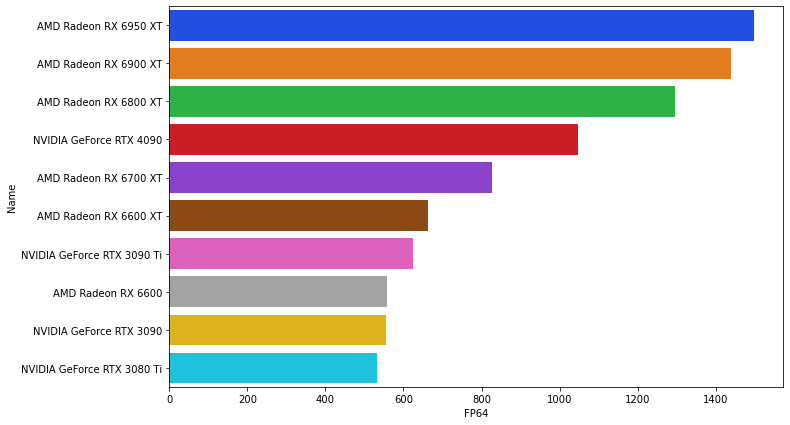

In [16]:
top10_FP64 = df.sort_values(by='FP64', ascending=False).head(10)
fig, axs = plt.subplots(figsize=(11,7))
sns.set_palette("bright")
sns.barplot(x="FP64", y="Name", data=top10_FP64)


<AxesSubplot:xlabel='FP32', ylabel='Name'>

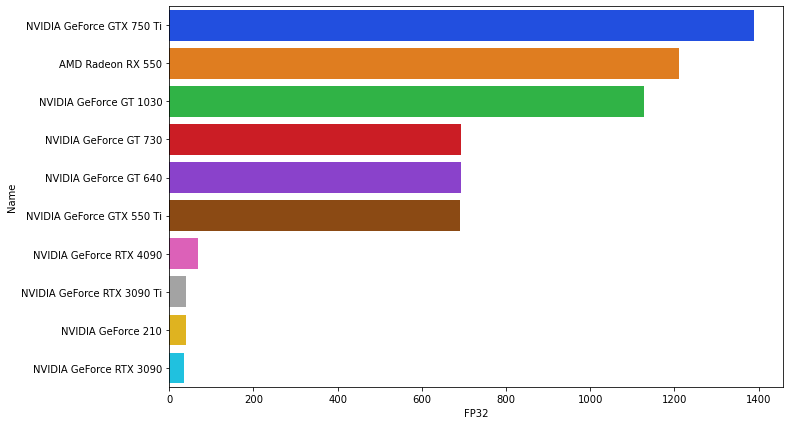

In [18]:
top10_FP32 = df.sort_values(by='FP32', ascending=False).head(10)
fig, axs = plt.subplots(figsize=(11,7))
sns.set_palette("bright")
sns.barplot(x="FP32", y="Name", data=top10_FP32)

<AxesSubplot:xlabel='FP16', ylabel='Name'>

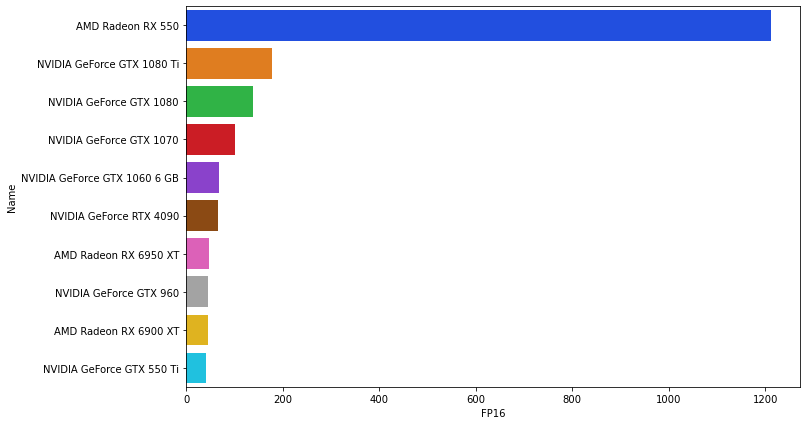

In [19]:
top10_FP16 = df.sort_values(by='FP16', ascending=False).head(10)
fig, axs = plt.subplots(figsize=(11,7))
sns.set_palette("bright")
sns.barplot(x="FP16", y="Name", data=top10_FP16)

Text(0.5, 1.01, 'EDA Overview')

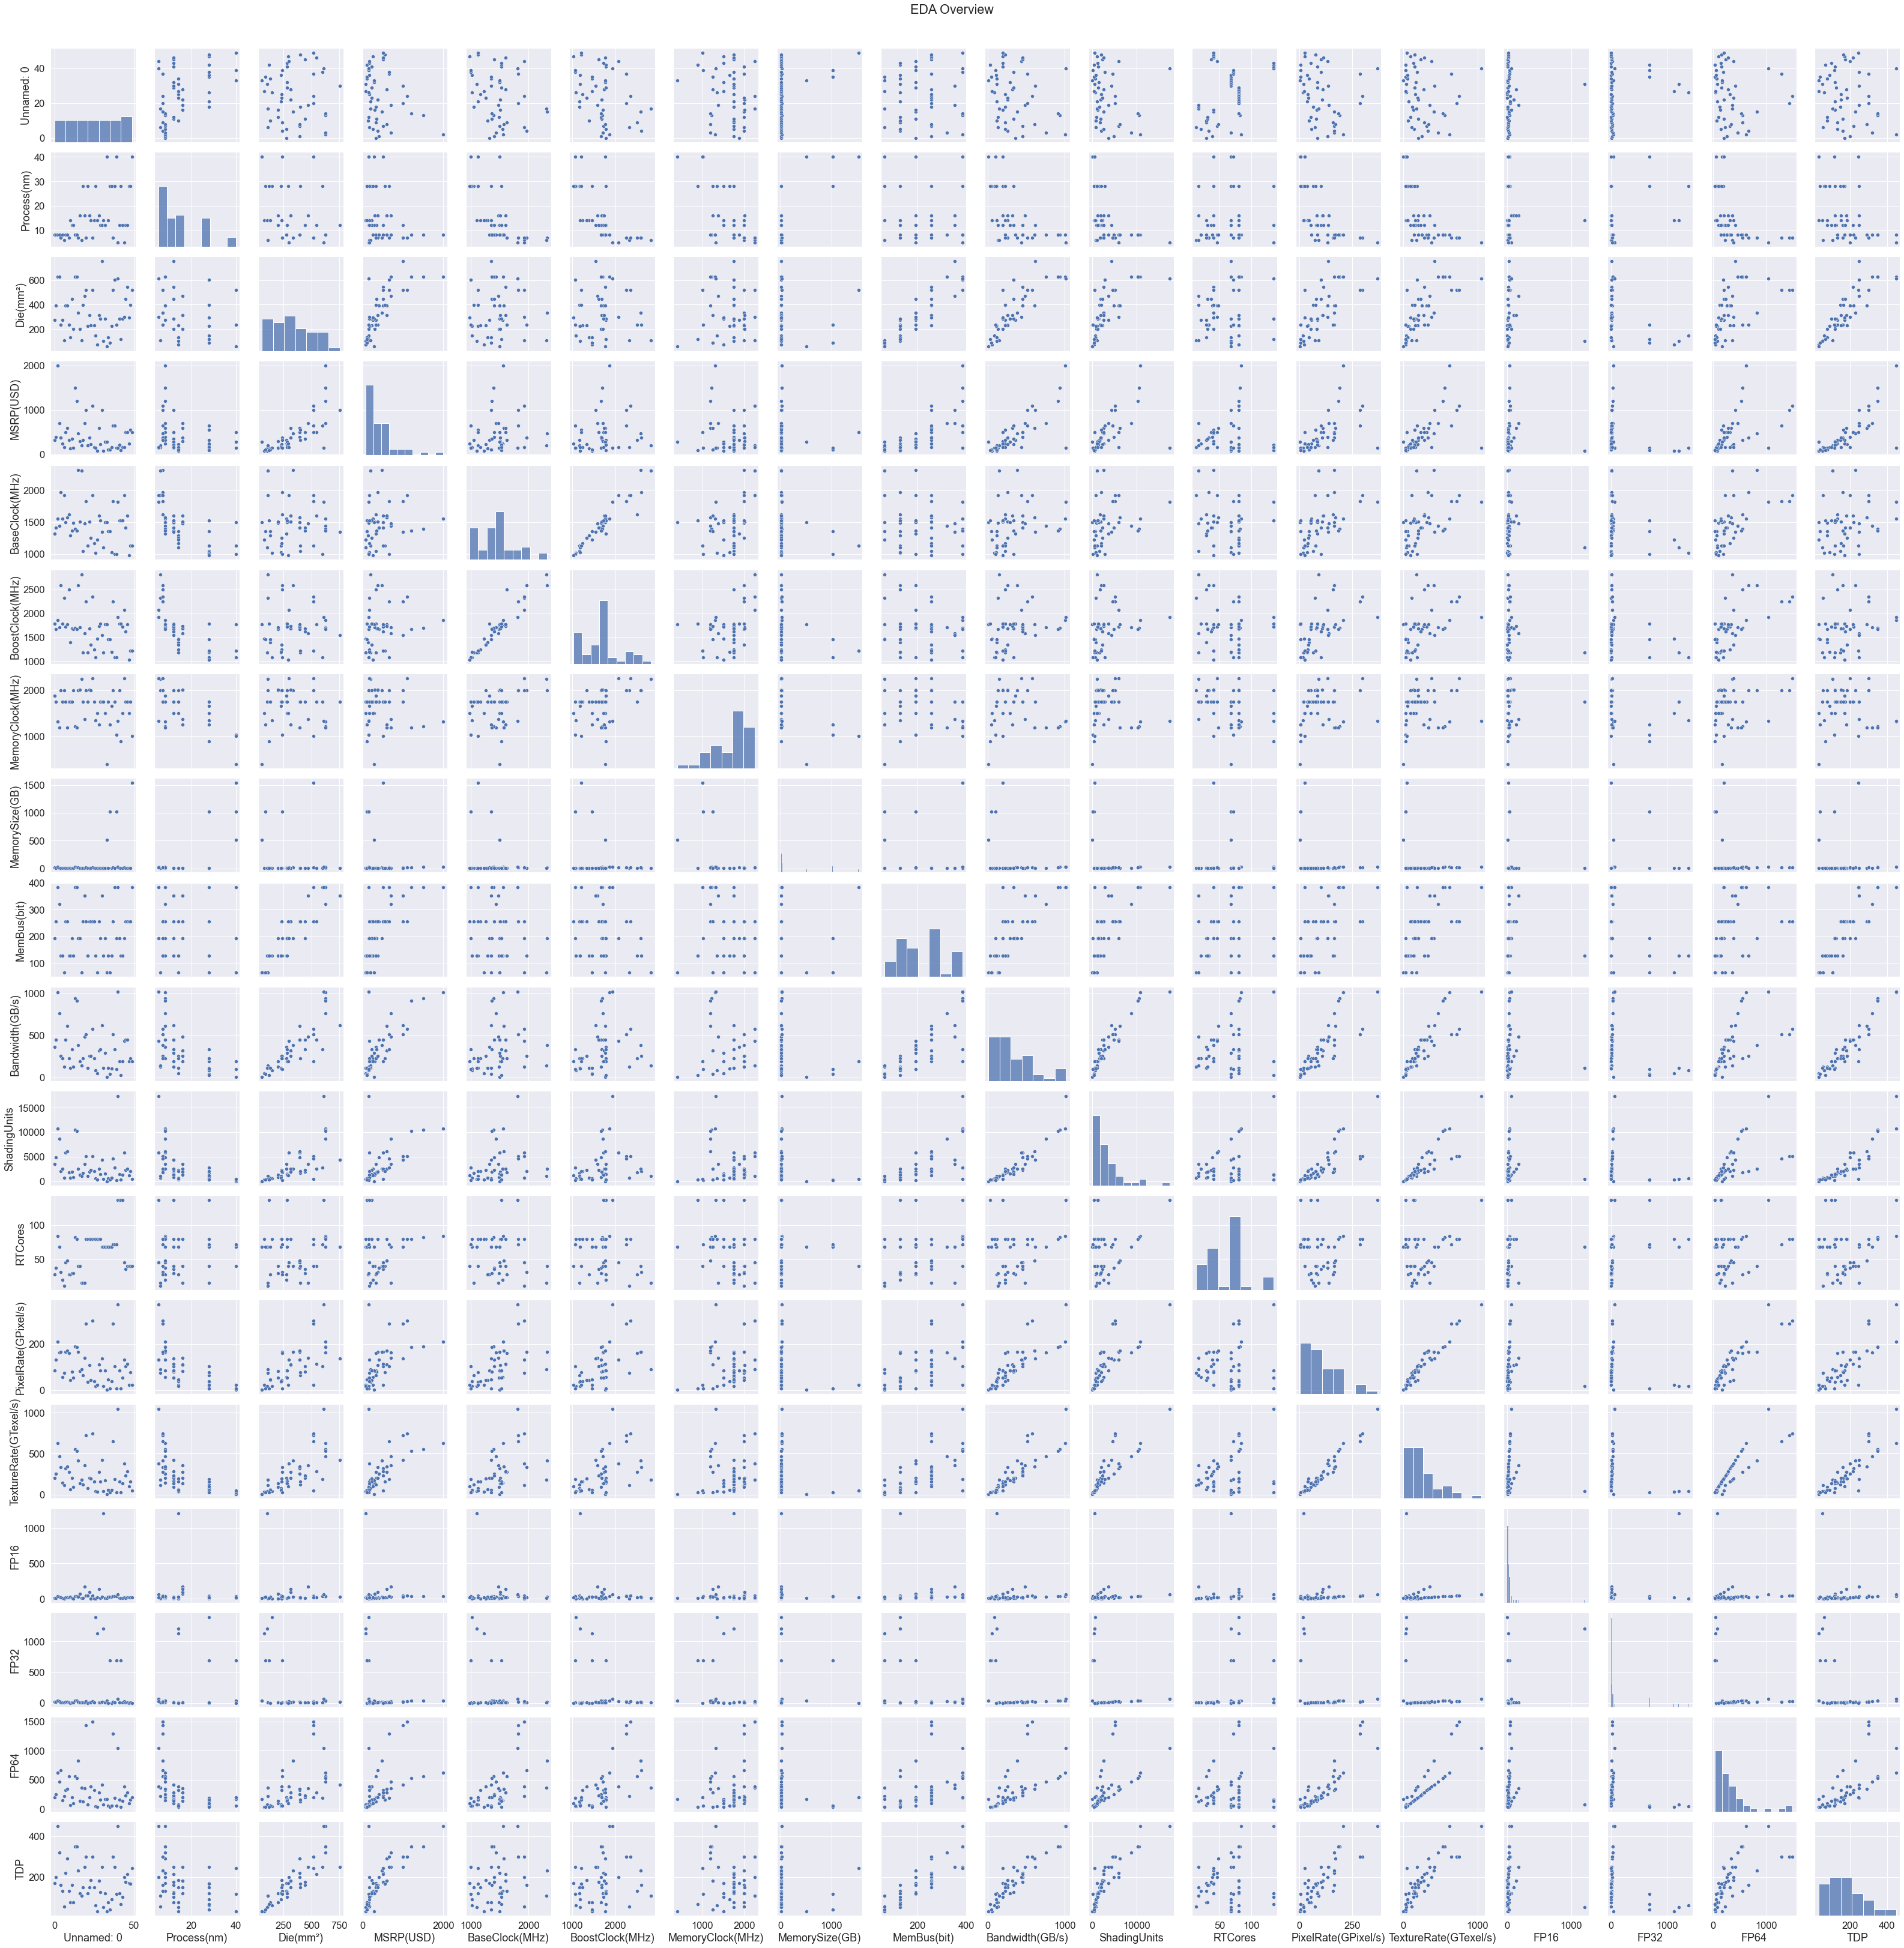

In [6]:
sns.set(font_scale = 1.5)
g = sns.pairplot(df)
g.fig.suptitle('EDA Overview', y = 1.01)